# Necessary Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Is CUDA available: ", torch.cuda.is_available())
print("PyTorch version: ", torch.__version__)

Is CUDA available:  False
PyTorch version:  2.2.1+cu121


#Dataset Class

In [3]:
class UltrasoundDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.annotations.iloc[idx, 1:].values.astype('float')

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': torch.tensor(label)}
        return sample

#Data Preprocessing  and using new ground truth

In [4]:
# Define the path to your images and CSV file
csv_file = '/content/drive/MyDrive/Origin_Medical/new_GROUND_TRUTH_coordinates.csv'
root_dir = '/content/drive/MyDrive/Origin_Medical/Task - Landmark/images'

In [5]:
df=pd.read_csv(csv_file)
df

,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,495,415,323,340,364,480,454,275
1,002_HC.png,137,258,430,125,204,16,363,367
2,010_HC.png,217,251,481,249,347,94,350,405
3,010_2HC.png,483,272,216,240,331,412,368,101
4,001_HC.png,416,309,388,133,290,239,515,204
...,...,...,...,...,...,...,...,...,...
617,495_HC.png,393,382,390,130,232,258,551,255
618,499_2HC.png,410,488,425,97,190,284,645,301
619,499_HC.png,386,498,366,117,138,320,614,295
620,498_HC.png,397,467,410,74,130,261,678,279


In [6]:
dataset = UltrasoundDataset(csv_file=csv_file, root_dir=root_dir)

In [ ]:
#print(set(image_check_size))

{(794, 544), (790, 539), (800, 540), (797, 541), (780, 544), (783, 543), (780, 539), (799, 563), (794, 543), (788, 545), (786, 542), (800, 542), (738, 541), (782, 542), (783, 541)}


In [ ]:
#print(len(set(image_check_size)))

15


In [7]:
image_folder_path = root_dir
# Assumed dimensions used during model training
output_width, output_height = 224, 224

for index, row in df.iterrows():
    image_path = os.path.join(image_folder_path, row['image_name'])

    with Image.open(image_path) as img:
        original_width, original_height = img.size  # Original dimensions of the image


        scaling_factor_width = output_width / original_width
        scaling_factor_height = output_height / original_height

        # Convert the coordinates from the original image dimensions to the resized image dimensions
        df.at[index, 'ofd_1_x'] *= scaling_factor_width
        df.at[index, 'ofd_1_y'] *= scaling_factor_height
        df.at[index, 'ofd_2_x'] *= scaling_factor_width
        df.at[index, 'ofd_2_y'] *= scaling_factor_height
        df.at[index, 'bpd_1_x'] *= scaling_factor_width
        df.at[index, 'bpd_1_y'] *= scaling_factor_height
        df.at[index, 'bpd_2_x'] *= scaling_factor_width
        df.at[index, 'bpd_2_y'] *= scaling_factor_height

new_csv_file = '/content/drive/MyDrive/Origin_Medical/NEW_normalized_coordinates_GT.csv'
df.to_csv(new_csv_file, index=False)

print("Normalization complete and data saved to 'NEW_normalized_coordinates_GT.csv'.")


Normalization complete and data saved to 'NEW_normalized_coordinates_GT.csv'.


In [9]:
df

,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,138.600000,172.148148,90.440000,141.037037,101.920000,199.111111,127.120000,114.074074
1,002_HC.png,38.360000,107.022222,120.400000,51.851852,57.120000,6.637037,101.640000,152.237037
2,010_HC.png,60.760000,104.118519,134.680000,103.288889,97.160000,38.992593,98.000000,168.000000
3,010_2HC.png,135.240000,112.829630,60.480000,99.555556,92.680000,170.903704,103.040000,41.896296
4,001_HC.png,116.480000,128.177778,108.640000,55.170370,81.200000,99.140741,144.200000,84.622222
...,...,...,...,...,...,...,...,...,...
617,495_HC.png,110.040000,158.459259,109.200000,53.925926,64.960000,107.022222,154.280000,105.777778
618,499_2HC.png,114.800000,202.429630,119.000000,40.237037,53.200000,117.807407,180.600000,124.859259
619,499_HC.png,108.080000,206.577778,102.480000,48.533333,38.640000,132.740741,171.920000,122.370370
620,498_HC.png,111.160000,193.718519,114.800000,30.696296,36.400000,108.266667,189.840000,115.733333


In [10]:
# Create the dataset
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((224, 224))])

In [11]:
dataset = UltrasoundDataset(csv_file=new_csv_file, root_dir=root_dir,transform=transform)

In [12]:
dataset[0]

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'label': tensor([138.6000, 172.1481,  90.4400, 141.0370, 101.9200, 199.1111, 127.1200,
         114.0741], dtype=torch.float64)}

#Train and validation split for loaders

In [13]:
from torch.utils.data import Subset

# Parameters
test_size = 0.2  # 20% for validation
random_state = 42

#split data indices into training and validation indices
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    test_size=test_size,
    random_state=random_state
)

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)


#Model definition

In [25]:
class LandmarkDetectionCNN(nn.Module):
    def __init__(self):
        super(LandmarkDetectionCNN, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.convs = nn.Sequential(
            self.conv1,
            self.pool,
            self.conv2,
            self.pool,
            self.conv3,
            self.pool
        )
        # self._to_linear = None

        self.fc1 = nn.Linear(4*224*224, 1000)
        self.fc2 = nn.Linear(1000, 8)

    def forward(self, x):
        x = self.convs(x)

        # if self._to_linear is None:

            # self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            # self._to_linear = x.shape[0] * x.shape[1] * x.shape[2]

            # self.fc1 = nn.Linear(self._to_linear, 1000)
            # self.fc2 = nn.Linear(1000, 8)  # 4 landmarks * 2 coordinates = 8

        # if torch.cuda.is_available():
        #     self.fc1.cuda()
        #     self.fc2.cuda()

        x = x.view(-1, 4*224*224)  # Flattening the convs' outputs
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = LandmarkDetectionCNN()

In [16]:
model = LandmarkDetectionCNN()
print(model)

LandmarkDetectionCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features

# Training the model

In [16]:
# Loss Function
criterion = nn.MSELoss()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
from tqdm import tqdm

In [19]:
# Parameters
epochs = 33
print_every = 50  # How often to print the loss and other info
# accumulation_steps = 4  # Accumulate gradients over 4 mini-batches

train_losses = []
val_losses = []
model = LandmarkDetectionCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
# Training and validation loop
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    optimizer.zero_grad()  # Move zeroing of the gradients outside the inner loop
    t = tqdm(dataset, desc=f"Epoch {epoch+1}", unit="batch")
    #for data in t:
    for i, data in enumerate(t):
      inputs, labels = data['image'].to(device), data['label'].to(device)
      inputs = inputs.float()
      labels = labels.to(torch.int64).float()

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, labels)
      optimizer.zero_grad()

      # Backward pass
      loss.backward()
      optimizer.step()


      t.set_postfix(loss=loss.item())

    # Append the average training loss for this epoch
    train_losses.append(loss)

    # Step the optimizer if the last batch was not a full accumulation set
    # if len(train_loader) % accumulation_steps != 0:
    #     optimizer.step()
    #     optimizer.zero_grad()

    # Validation Phase
        # Validation Phase
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    val_steps = 0  # Keep track of number of batches processed

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for data in val_loader:
            inputs, labels = data['image'].to(device), data['label'].to(device)
            inputs = inputs.float()
            labels = labels.to(torch.int64).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()
            val_steps += 1

    if val_steps > 0:
        average_validation_loss = validation_loss / val_steps
    else:
        average_validation_loss = 0

    val_losses.append(average_validation_loss)
    print(f'Epoch {epoch+1}, Validation Loss: {validation_loss/len(val_loader):.3f}')


print('Finished Training')


Epoch 1:   0%|          | 0/622 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1: 100%|██████████| 622/622 [00:29<00:00, 20.77batch/s, loss=282]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Validation Loss: 768.488


Epoch 2: 100%|██████████| 622/622 [00:25<00:00, 24.06batch/s, loss=260]


Epoch 2, Validation Loss: 747.475


Epoch 3: 100%|██████████| 622/622 [00:24<00:00, 25.45batch/s, loss=223]


Epoch 3, Validation Loss: 734.690


Epoch 4: 100%|██████████| 622/622 [00:23<00:00, 26.46batch/s, loss=197]


Epoch 4, Validation Loss: 717.074


Epoch 5: 100%|██████████| 622/622 [00:25<00:00, 24.14batch/s, loss=167]


Epoch 5, Validation Loss: 699.837


Epoch 6: 100%|██████████| 622/622 [00:24<00:00, 25.21batch/s, loss=158]


Epoch 6, Validation Loss: 683.636


Epoch 7: 100%|██████████| 622/622 [00:23<00:00, 26.14batch/s, loss=163]


Epoch 7, Validation Loss: 670.843


Epoch 8: 100%|██████████| 622/622 [00:27<00:00, 22.82batch/s, loss=153]


Epoch 8, Validation Loss: 665.157


Epoch 9: 100%|██████████| 622/622 [00:29<00:00, 20.95batch/s, loss=139]


Epoch 9, Validation Loss: 656.822


Epoch 10: 100%|██████████| 622/622 [00:24<00:00, 25.55batch/s, loss=127]


Epoch 10, Validation Loss: 650.175


Epoch 11: 100%|██████████| 622/622 [00:28<00:00, 21.88batch/s, loss=111]


Epoch 11, Validation Loss: 643.268


Epoch 12: 100%|██████████| 622/622 [00:28<00:00, 22.05batch/s, loss=113]


Epoch 12, Validation Loss: 634.739


Epoch 13: 100%|██████████| 622/622 [00:24<00:00, 25.35batch/s, loss=111]


Epoch 13, Validation Loss: 630.677


Epoch 14: 100%|██████████| 622/622 [00:25<00:00, 24.02batch/s, loss=111]


Epoch 14, Validation Loss: 625.906


Epoch 15: 100%|██████████| 622/622 [00:23<00:00, 26.37batch/s, loss=119]


Epoch 15, Validation Loss: 623.159


Epoch 16: 100%|██████████| 622/622 [00:24<00:00, 25.72batch/s, loss=120]


Epoch 16, Validation Loss: 619.907


Epoch 17: 100%|██████████| 622/622 [00:24<00:00, 25.70batch/s, loss=124]


Epoch 17, Validation Loss: 608.872


Epoch 18: 100%|██████████| 622/622 [00:24<00:00, 25.32batch/s, loss=125]


Epoch 18, Validation Loss: 605.669


Epoch 19: 100%|██████████| 622/622 [00:28<00:00, 21.55batch/s, loss=129]


Epoch 19, Validation Loss: 601.994


Epoch 20: 100%|██████████| 622/622 [00:28<00:00, 21.88batch/s, loss=115]


Epoch 20, Validation Loss: 592.617


Epoch 21: 100%|██████████| 622/622 [00:26<00:00, 23.76batch/s, loss=99.2]


Epoch 21, Validation Loss: 588.098


Epoch 22: 100%|██████████| 622/622 [00:25<00:00, 24.30batch/s, loss=94]


Epoch 22, Validation Loss: 581.784


Epoch 23: 100%|██████████| 622/622 [00:24<00:00, 24.96batch/s, loss=101]


Epoch 23, Validation Loss: 573.040


Epoch 24: 100%|██████████| 622/622 [00:25<00:00, 24.38batch/s, loss=98.2]


Epoch 24, Validation Loss: 564.575


Epoch 25: 100%|██████████| 622/622 [00:28<00:00, 21.65batch/s, loss=99.6]


Epoch 25, Validation Loss: 558.817


Epoch 26: 100%|██████████| 622/622 [00:24<00:00, 25.08batch/s, loss=104]


Epoch 26, Validation Loss: 552.278


Epoch 27: 100%|██████████| 622/622 [00:23<00:00, 26.23batch/s, loss=95]


Epoch 27, Validation Loss: 544.453


Epoch 28: 100%|██████████| 622/622 [00:23<00:00, 26.72batch/s, loss=90.6]


Epoch 28, Validation Loss: 539.308


Epoch 29: 100%|██████████| 622/622 [00:23<00:00, 26.36batch/s, loss=87.6]


Epoch 29, Validation Loss: 532.778


Epoch 30: 100%|██████████| 622/622 [00:23<00:00, 26.59batch/s, loss=86.5]


Epoch 30, Validation Loss: 520.654


Epoch 31: 100%|██████████| 622/622 [00:23<00:00, 26.11batch/s, loss=86.8]


Epoch 31, Validation Loss: 511.718


Epoch 32: 100%|██████████| 622/622 [00:26<00:00, 23.14batch/s, loss=84.3]


Epoch 32, Validation Loss: 501.660


Epoch 33: 100%|██████████| 622/622 [00:24<00:00, 25.36batch/s, loss=85.1]


Epoch 33, Validation Loss: 498.119
Finished Training


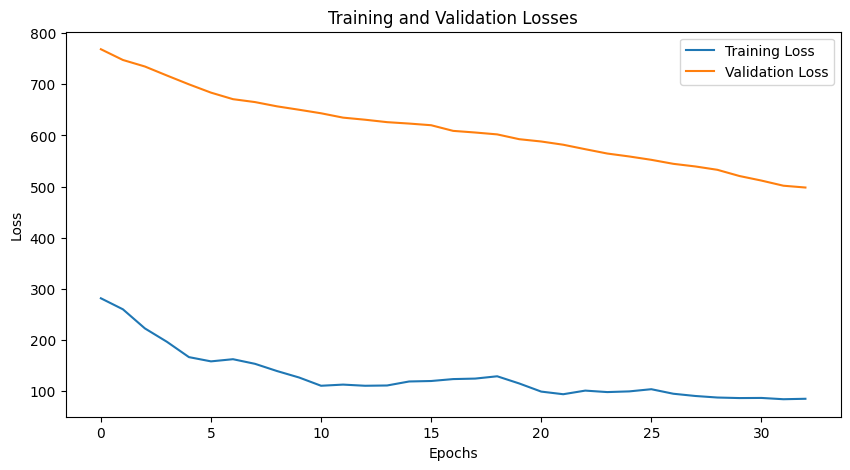

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_losses' is a list of tensors on the GPU and 'val_losses' is a list of floats
plt.figure(figsize=(10, 5))

# Process the train losses: detach, move to CPU, convert to numpy, and extract their values
train_losses_np = [loss.detach().cpu().numpy() for loss in train_losses]

# Convert val losses to a numpy array directly since they are plain floats
val_losses_np = np.array(val_losses)

plt.plot(train_losses_np, label='Training Loss')
plt.plot(val_losses_np, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
print(train_losses,val_losses)

[tensor(281.6053, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(260.0573, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(222.6762, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(196.5114, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(166.5647, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(158.2767, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(162.5029, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(153.4689, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(139.3640, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(126.7586, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(110.5938, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(112.8489, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(110.5836, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(111.1219, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(118.9560, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(119.8784, device='cuda:0', grad_fn=<MseLossBack

## Saved losses for checking

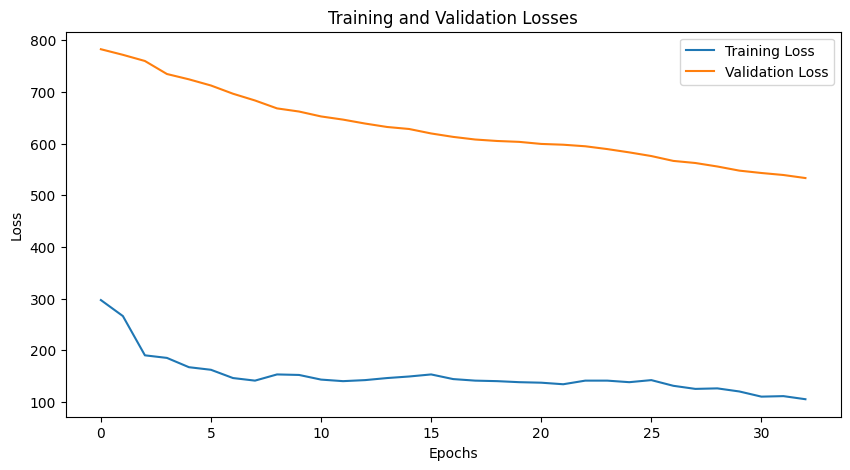

In [ ]:
import matplotlib.pyplot as plt

# Sample train and validation losses, replace these with your actual losses
train_losses = [
    297, 266, 190, 185, 167, 162, 146, 141, 153, 152,
    143, 140, 142, 146, 149, 153, 144, 141, 140, 138,
    137, 134, 141, 141, 138, 142, 131, 125, 126, 120,
    110, 111, 105
]
val_losses = [
    782.739, 771.899, 759.947, 734.745, 724.431, 712.481, 696.571, 683.492, 668.174, 662.085,
    652.586, 646.433, 638.814, 632.165, 628.276, 619.614, 612.990, 607.900, 605.049, 603.341,
    599.351, 597.821, 594.824, 589.372, 582.977, 575.888, 566.471, 562.415, 555.653, 547.629,
    543.071, 539.185, 533.267
]

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Cheked previous ground truth on resized image

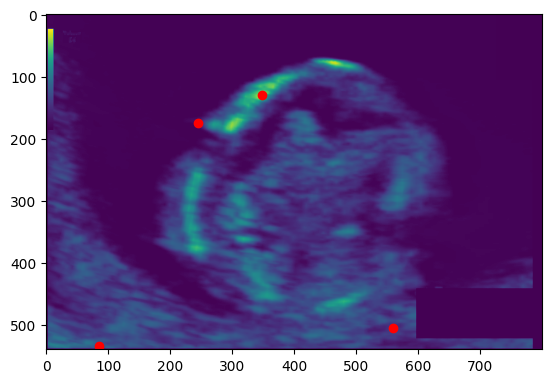

In [ ]:
def plot_image_with_dots(image_path, coordinates):
    image = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, len(coordinates), 2):
        x, y = coordinates[i], coordinates[i+1]
        ax.plot(x, y, 'ro')
    plt.show()
image_path = "/content/drive/MyDrive/Origin_Medical/Task - Landmark/images/011_HC.png"
coordinates = [348,	129,	85,	535	,244,	175,	559,	505]
plot_image_with_dots(image_path, coordinates)


# checking again the new ground truth on original image

torch.Size([224, 224])
tensor([138.6000, 172.1481,  90.4400, 141.0370, 101.9200, 199.1111, 127.1200,
        114.0741], dtype=torch.float64)


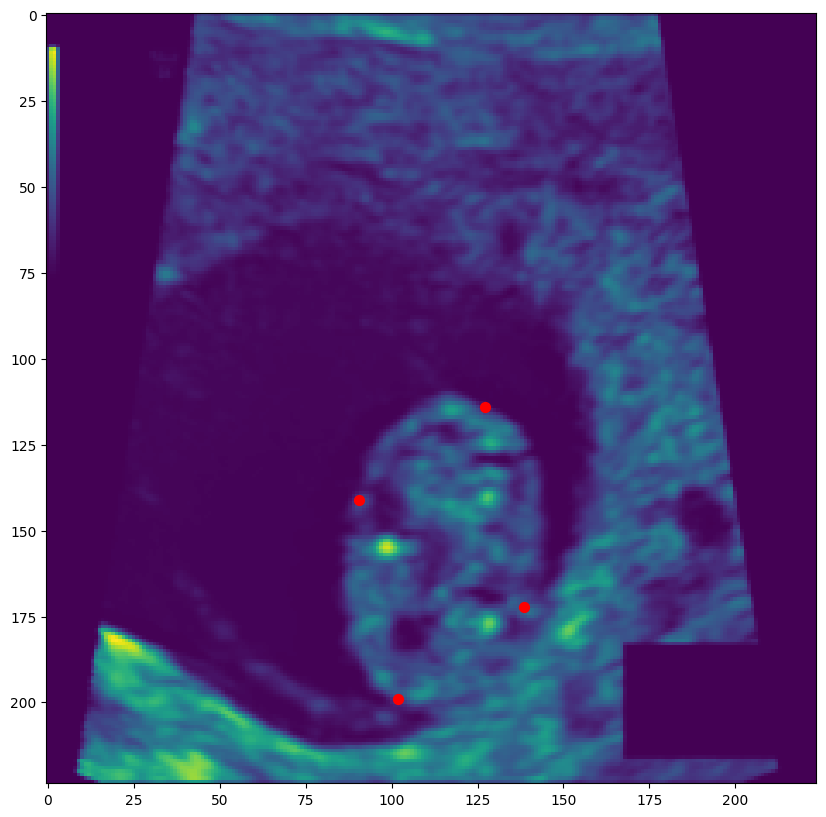

In [ ]:
images = dataset[0]['image'].squeeze()
print(images.shape)
plt.figure(figsize=(15, 10))
plt.imshow(images.cpu())
normalized_labels = dataset[0]['label'].cpu()
print(normalized_labels)
for j in range(0, len(normalized_labels)//2):
    x, y = normalized_labels[2*j], normalized_labels[2*j+1]
    plt.scatter(x, y, c='red', s=50)

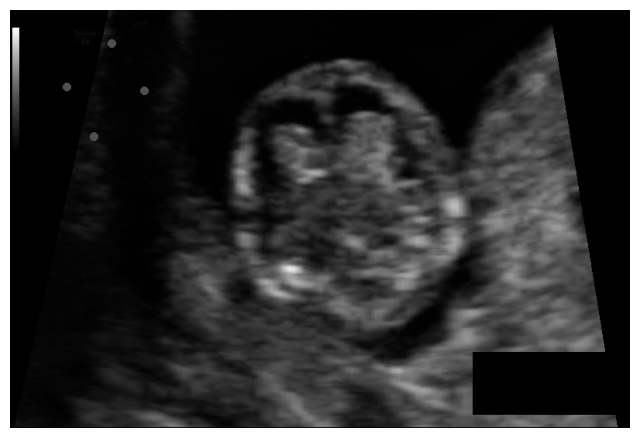

In [ ]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms

def preprocess_image(image_path, transform=None):

    img = Image.open(image_path).convert('L')  # Convert to grayscale
    if transform:
        img = transform(img)
    return img

def predict_points(model, image_tensor):
    # disable gradient computation
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor.unsqueeze(0))
        predicted_points = outputs.cpu().numpy().flatten()
    return predicted_points

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

image_path = '/content/drive/MyDrive/Origin_Medical/Task - Landmark/images/006_HC.png'
image = preprocess_image(image_path, transform)

predicted_points = predict_points(model, image)

predicted_points = predicted_points.reshape(-1, 2)


img = Image.open(image_path).convert('L')
draw = ImageDraw.Draw(img)
for point in predicted_points:

    x, y = point
    r = 5
    draw.ellipse((x - r, y - r, x + r, y + r), fill='red')


plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


# Reshape and Scale Predicted point...

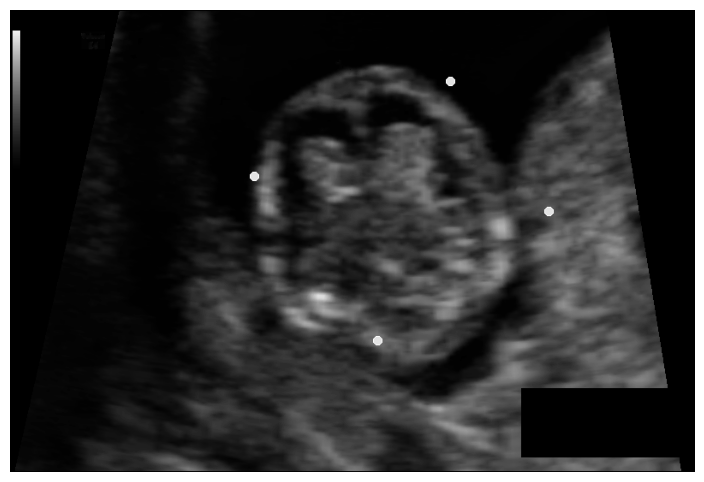

In [33]:
def preprocess_image(image_path, transform=None):
    img_original = Image.open(image_path).convert('L')
    img_transformed = transform(img_original) if transform else img_original
    return img_original, img_transformed


def predict_points(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor.unsqueeze(0))
        predicted_points = outputs.cpu().numpy().flatten()  # Convert to numpy and flatten
    return predicted_points


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


image_path = '/content/drive/MyDrive/Origin_Medical/Task - Landmark/images/006_HC.png'
img_original, img_transformed = preprocess_image(image_path, transform)

# Predict biometry points on the transformed image
predicted_points = predict_points(model, img_transformed)

# Reshape and scale the predicted points
predicted_points = predicted_points.reshape(-1, 2)
original_width, original_height = img_original.size
scale_x = original_width / 224
scale_y = original_height / 224
scaled_points = [(x * scale_x, y * scale_y) for x, y in predicted_points]

# Visualize the predicted points on the original image
draw = ImageDraw.Draw(img_original)
for x, y in scaled_points:
    r = 5
    draw.ellipse((x - r, y - r, x + r, y + r), fill='yellow', outline='white')


plt.figure(figsize=(10, 6))
plt.imshow(img_original, cmap='gray')
plt.axis('off')
plt.show()


# Model was **not learning** because ground truth was incorrect

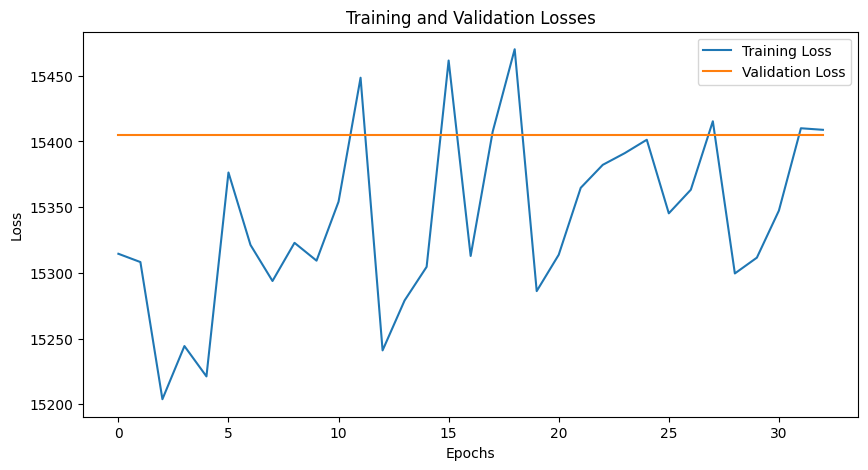

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Did some exploration on validation dataset if there were any discripancies or not

In [ ]:
# Check the first batch in the validation dataset
data_iter = iter(val_loader)
first_batch = next(data_iter)
inputs, labels = first_batch['image'].to(device), first_batch['label'].to(device)

print("Shape of inputs:", inputs.shape)
print("Shape of labels:", labels.shape)

print("Data type of inputs:", inputs.dtype)
print("Data type of labels:", labels.dtype)


Shape of inputs: torch.Size([8, 1, 224, 224])
Shape of labels: torch.Size([8, 8])
Data type of inputs: torch.float32
Data type of labels: torch.float64


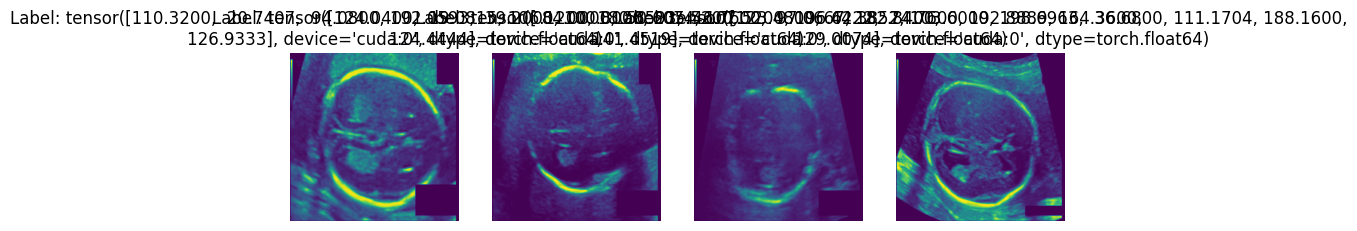

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=4):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

images = inputs[:4]
normalized_labels = labels[:4]
show_images(images, normalized_labels)


In [ ]:
print("Mean of inputs:", inputs.mean())
print("Std of inputs:", inputs.std())
print("Max of inputs:", inputs.max())
print("Min of inputs:", inputs.min())
print("Unique labels:", labels.unique())


Mean of inputs: tensor(0.1652, device='cuda:0')
Std of inputs: tensor(0.1780, device='cuda:0')
Max of inputs: tensor(0.9529, device='cuda:0')
Min of inputs: tensor(0., device='cuda:0')
Unique labels: tensor([ 19.0815,  20.7407,  23.6444,  31.3600,  36.6800,  39.2000,  44.3852,
         46.7600,  47.7037,  50.6074,  53.0963,  56.0000,  58.5200,  58.9037,
         64.9600,  70.9333,  74.7600,  82.6000,  84.0000,  94.0800,  94.9926,
         97.0667, 100.5200, 100.8000, 103.6000, 104.9481, 106.1200, 107.5200,
        110.3200, 111.1600, 111.1704, 111.5852, 112.8296, 113.2444, 116.7600,
        120.6800, 122.6400, 123.4800, 124.0400, 124.4444, 126.9333, 128.5200,
        129.0074, 134.4000, 134.9600, 141.4519, 143.1111, 154.0000, 162.1926,
        163.8519, 164.3600, 165.5111, 180.8593, 182.8400, 184.1778, 188.1600,
        192.0593, 192.8889, 193.2000, 194.5481, 196.6222, 198.6963, 205.5200,
        209.4400], device='cuda:0', dtype=torch.float64)


In [ ]:
model.eval()
outputs = model(inputs)
print("Output example:", outputs[:4])

print("Unique values in outputs:", outputs.unique())

Output example: tensor([[-0.0354,  0.0071, -0.0125, -0.0271, -0.0147, -0.0300,  0.0475,  0.0041],
        [-0.0244,  0.0090, -0.0059, -0.0329, -0.0171, -0.0295,  0.0450, -0.0079],
        [-0.0381,  0.0027, -0.0129, -0.0207, -0.0063, -0.0267,  0.0473,  0.0089],
        [-0.0481, -0.0056, -0.0102, -0.0233, -0.0113, -0.0228,  0.0621,  0.0043]],
       device='cuda:0', grad_fn=<SliceBackward0>)
Unique values in outputs: tensor([-0.0562, -0.0554, -0.0527, -0.0481, -0.0381, -0.0354, -0.0351, -0.0329,
        -0.0300, -0.0295, -0.0271, -0.0267, -0.0264, -0.0253, -0.0244, -0.0233,
        -0.0231, -0.0228, -0.0207, -0.0197, -0.0175, -0.0171, -0.0167, -0.0147,
        -0.0145, -0.0135, -0.0132, -0.0129, -0.0125, -0.0113, -0.0111, -0.0109,
        -0.0106, -0.0102, -0.0101, -0.0085, -0.0079, -0.0073, -0.0063, -0.0061,
        -0.0059, -0.0056, -0.0051, -0.0043, -0.0032,  0.0010,  0.0012,  0.0027,
         0.0041,  0.0043,  0.0071,  0.0075,  0.0089,  0.0090,  0.0092,  0.0124,
         0.0450,  0

# Saving model weights

In [8]:
model_path = '/content/drive/MyDrive/Origin_Medical/final_landmark_detection_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [9]:
state_dict = torch.load(model_path, map_location='cpu')

print("Loaded state_dict keys:")
print(state_dict.keys())

model = LandmarkDetectionCNN()
print("\nExpected state_dict keys from the model definition:")
print(model.state_dict().keys())


Loaded state_dict keys:
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'convs.0.weight', 'convs.0.bias', 'convs.2.weight', 'convs.2.bias', 'convs.4.weight', 'convs.4.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

Expected state_dict keys from the model definition:
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'convs.0.weight', 'convs.0.bias', 'convs.2.weight', 'convs.2.bias', 'convs.4.weight', 'convs.4.bias'])


In [26]:
model = LandmarkDetectionCNN()#.to(device)
model_path = '/content/drive/MyDrive/Origin_Medical/final_landmark_detection_model.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>